# Quantum walk


This example provides an implementation of the discrete time quantum random walk algorithm (hereafter referred as quantum walk) using the Amazon Braket SDK. 
One application of quantum walks is to search and find graph properties, including marked vertices, maximal cliques, just to name a few. These problems can be solved via quantum walks provided an oracle that knows the properties of the graph is given. 
We will not get into the details of solving such problems; instead, we will illustrate how to transverse a circular graph, a graph consists of a single cycle, with a quantum walker. 


The quantum walk is very similar to the classical walk, where a walker observes a random process, such as flipping a coin, followed by deciding its next step conditioned on the outcome of the random process. For quantum walker, it observes a quantum process instead, and the subsequent steps are superpositions of the possible steps that a classical walker would take. For example, in this notebook, we consider a quantum walker on a cycle with $N=2^n$ nodes, where each node has only two neighbors. As a result, a classical walker would have two choices at each step, either going to the left or right neighbor, whereas it would be a superposition of the two for the quantum walker. 
More concretely, we will use $|q, k\rangle$ to denote the state of a quantum walker where $q=0,1$ is the state of the coin, and $k\in\left\{0,..,N-1\right\}$ labels the node. 
Each step of the quantum walk is a product of the coin operator (C) and the shift operator (S). 
The coin operator could in principle be any unitary that mixes the coin states, but for simplicity, we use the Hadamard gate 
\begin{align}
C|q,k\rangle = H\otimes I|q,k\rangle = \frac{1}{\sqrt{2}}(|0,k\rangle + (-1)^q|1,k\rangle).
\end{align}
The shift operator moves the walker to the neighboring nodes conditioned on the outcomes of the toss coin followed by flipping the coin state
\begin{align}
S|q,k\rangle = |q\oplus 1, k\oplus(-1)^q\rangle
\end{align}
where $\oplus$ denotes the modular addition: for the first register, the addition is modulo 2 since there are only 2 states for the coin, whereas the addition is modulo $N$ for the second register. 
The quantum walk then proceeds by applying these two operators in alternation, and a $p$ step quantum walk is just the operator $(SC)^p$. 

How do we realize a quantum circuit to perform conditional modular addition? In order to perform modular addition and subtraction, one could invoke the quantum Fourier transform (QFT) adder introduced in Ref. [2](https://arxiv.org/abs/1411.5949). Here we will modify the QFT adder for performing conditional modular addition for the quantum walker. For more details, we refer the readers to the Appendix.



# References

[[1] Quantum Algorithm Implementations for Beginners](https://arxiv.org/abs/1804.03719)

[[2] Quantum arithmetic with the Quantum Fourier Transform](https://arxiv.org/abs/1411.5949)

We start by importing the necessary functions

In [1]:
from braket.devices import LocalSimulator
from braket.aws import AwsDevice

import numpy as np

from quantum_walk import run_quantum_walk, quantum_walk, plot_bitstrings

# Quantum walk on a graph with four nodes

As an example, we consider the quantum walk on a graph with 4 nodes as shown in the figure below. Without loss of generality, we shall assume that the walker starts from the vertex labeled as 0. We will demonstrate, step by step, that how the walker transverse around the graph, and arrive at the opposite corner of the graph.

For that, we define the quantum circuits for quantum walks with 1, 2, and 4 steps.

In [2]:
quantum_walk_circuit_4_nodes_1_step = quantum_walk(4, 1)
quantum_walk_circuit_4_nodes_2_steps = quantum_walk(4, 2)
quantum_walk_circuit_4_nodes_3_steps = quantum_walk(4, 3)
quantum_walk_circuit_4_nodes_4_steps = quantum_walk(4, 4)

We can visualize the quantum circuit for one-step quantum walk as follows. The $n$-step quantum walk for the same graph is simply the $n$-time repetition of the same circuit.

In [3]:
print(quantum_walk_circuit_4_nodes_1_step)

T  : |0|     1     |       2       |     3      |      4      |     5      |6|     7      |8|
                                                                                             
q0 : -H---------------C-------------C------------C-------------C------------X----------------
                      |             |            |             |                             
q1 : ---C-----------H-|-------------|------------PHASE01(3.14)-PHASE(-3.14)-H-C--------------
        |             |             |                                         |              
q2 : -H-PHASE(1.57)---PHASE01(1.57)-PHASE(-1.57)------------------------------PHASE(-1.57)-H-

T  : |0|     1     |       2       |     3      |      4      |     5      |6|     7      |8|


Before proceeding, let us explicitly calculate the states after each step of the quantum walk. Recall that we start with the $0$-th vertex and hence the initial state reads
\begin{align}
|\psi_0\rangle = |00\rangle
\end{align}
where the first register is the coin qubit. After the first step, we have
\begin{align}
|\psi_1\rangle \equiv (SC)|\psi_0\rangle = S\frac{1}{\sqrt{2}}\left(|0\rangle+|1\rangle\right)\otimes|0\rangle = \frac{1}{\sqrt{2}}\left(|11\rangle+|03\rangle\right)
\end{align}
where we have used the fact $-1\equiv3\text{ mod }4$. After this step, the walker will be in the superposition of the first and third nodes. For the second step we have
\begin{align}
|\psi_2\rangle \equiv (SC)|\psi_1\rangle = \frac{1}{2}\left[|12\rangle-|00\rangle+|10\rangle+|02\rangle\right]
\end{align}
where the walker will be in the superposition of the zeroth and the second nodes. For the third step we have \begin{align}
|\psi_3\rangle \equiv (SC)|\psi_2\rangle = \frac{1}{\sqrt{2}}(|1\rangle-|0\rangle)|3\rangle
\end{align}
where the walker will be in the third node deterministically after the third step. Finally, after the fourth step, we have
\begin{align}
|\psi_4\rangle \equiv (SC)|\psi_3\rangle = -|02\rangle
\end{align}
where the walker end up in the opposite corner, namely the second node, deterministically after the fourth step.

# Run the quantum walk on a local simulator

Let's now run the 4 quantum circuits on a local simulator, followed by measuring the qubits for the nodes. The measurement results are shown with bar plots. 

In [4]:
local_sim = LocalSimulator()
counts_4_nodes_1_step_sim = run_quantum_walk(quantum_walk_circuit_4_nodes_1_step, local_sim)
counts_4_nodes_2_steps_sim = run_quantum_walk(quantum_walk_circuit_4_nodes_2_steps, local_sim)
counts_4_nodes_3_steps_sim = run_quantum_walk(quantum_walk_circuit_4_nodes_3_steps, local_sim)
counts_4_nodes_4_steps_sim = run_quantum_walk(quantum_walk_circuit_4_nodes_4_steps, local_sim)

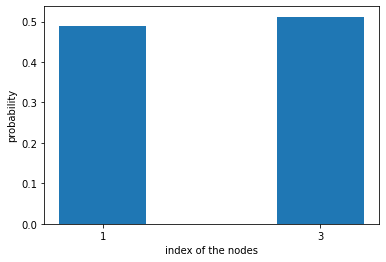

In [5]:
plot_bitstrings(counts_4_nodes_1_step_sim["quantum_walk_measurement_counts"])

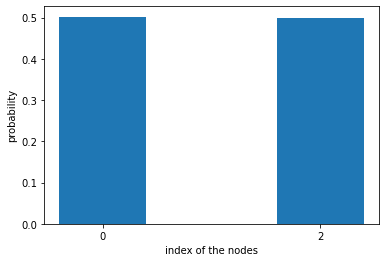

In [6]:
plot_bitstrings(counts_4_nodes_2_steps_sim["quantum_walk_measurement_counts"])

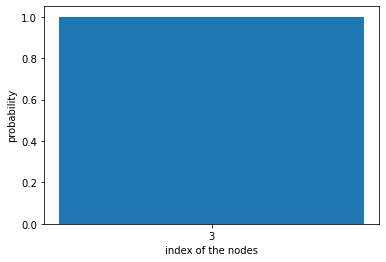

In [7]:
plot_bitstrings(counts_4_nodes_3_steps_sim["quantum_walk_measurement_counts"])

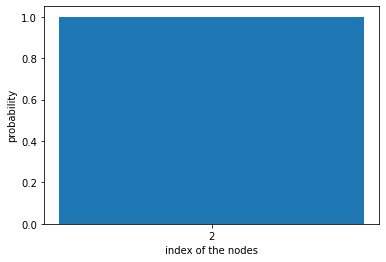

In [8]:
plot_bitstrings(counts_4_nodes_4_steps_sim["quantum_walk_measurement_counts"])

We see that the bar plots are consistent with our calculations for each step. One may be puzzled, after comparing the bar plots for the third and the fourth steps, that why the quantum walker can be shifted from the third node to its neighbor deterministically with a single step. 
This seems to be contrast to the very first step where the amplitude is evenly distributed to the neighbors of the zeroth node. 
The reason is that after the third step, despite the walker is deterministically found to be on the third node, the coin qubit is in a superposition state, in contrast to the very first step, where the coin is in the state of $|0\rangle$. 

# Run the quantum walk on a QPU

Let's now run the same quantum circuits on the Rigetti device, followed by inspecting the measurement results with bar plots.

Include estimated price for running in USD.


In [ ]:
qpu = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-2")
counts_4_nodes_1_step_qpu = run_quantum_walk(quantum_walk_circuit_4_nodes_1_step, qpu)
counts_4_nodes_2_steps_qpu = run_quantum_walk(quantum_walk_circuit_4_nodes_2_steps, qpu)
counts_4_nodes_3_steps_qpu = run_quantum_walk(quantum_walk_circuit_4_nodes_3_steps, qpu)
counts_4_nodes_4_steps_qpu = run_quantum_walk(quantum_walk_circuit_4_nodes_4_steps, qpu)

In [ ]:
plot_bitstrings(counts_4_nodes_1_step_qpu["quantum_walk_measurement_counts"])

In [ ]:
plot_bitstrings(counts_4_nodes_2_steps_qpu["quantum_walk_measurement_counts"])

In [ ]:
plot_bitstrings(counts_4_nodes_3_steps_qpu["quantum_walk_measurement_counts"])

In [ ]:
plot_bitstrings(counts_4_nodes_4_steps_qpu["quantum_walk_measurement_counts"])

Some comments of the noise

In [ ]:
print(
    f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD"
)

Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).

# Appendix: QFT adder and its variant

Here we review the QFT adder and its variant, which is used in the quantum walker circuit. 
Recall that QFT for an orthonormal basis $|0\rangle, |1\rangle, ..., |2^n-1\rangle$ is defined as
\begin{align}
    QFT|j\rangle = \frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1}e^{2\pi ijk/2^n}|k\rangle,
\end{align}
where $j=0, .., 2^n-1$, and the inverse QFT is 
\begin{align}
    IQFT|k\rangle = \frac{1}{\sqrt{2^n}}\sum_{j=0}^{2^n-1}e^{-2\pi ijk/2^n}|j\rangle, 
\end{align}
where $k=0, .., 2^n-1$. Here we shall use QFT to perform modular addition. In particular, given two integers $x, y$, we would like to obtain $x+y\mod 2^n$. For this purpose, we shall encode the binary representations of the two numbers into $|x\rangle, |y\rangle$ respectively, and introduce the control-Z operator 
\begin{align}
    CZ|x\rangle|y\rangle = e^{2\pi ixy/2^n}|x\rangle|y\rangle
\end{align} 
such that we have
\begin{align}
    (I\otimes IQFT)\cdot CZ\cdot (I\otimes QFT)|x\rangle|y\rangle = |x\rangle|x+y\text{ mod } 2^n\rangle
\end{align}
We will leave the detailed calculation to the interested readers. <!-- This is easy to see, as
\begin{align}
    &(I\otimes IQFT)\cdot CZ\cdot (I\otimes QFT)|x\rangle|y\rangle\\
    =&(I\otimes IQFT)\cdot CZ |x\rangle\frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1}e^{2\pi iyk/2^n}|k\rangle\\
    =&(I\otimes IQFT)\cdot |x\rangle\frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1}e^{2\pi i(x+y)k/2^n}|k\rangle\\
    =&|x\rangle\frac{1}{2^n}\sum_{y',k=0}^{2^n-1}e^{2\pi i(x+y-y')k/2^n}|y'\rangle\\
    =&|x\rangle\sum_{y'=0}^{2^n-1}\delta_{y', x+y\text{ mod } 2^n}|y'\rangle\\
    =&|x\rangle|x+y\text{ mod } 2^n\rangle
\end{align}
where the second to last line, we have $x+y$ mod $2^n$, because the integral multiple of $2^n$ won't have any effect on the exponential.  --> At the end of the circuit, we simply measure the second register to obtain the result. For two given numbers, in order to avoid the modular, we simply take a number $2^{\tilde{n}}$ that is larger than the possible outcome for the summation. 


Now, how to we implement the $CZ$ operator? The idea is that we will have x and y both in binary representations
\begin{align}
    x = \sum_{i=0}^{n-1}x_i2^i, \quad y = \sum_{j=0}^{n-1}y_j2^j
\end{align}
such that
\begin{align}
    e^{i2\pi xy/2^n} = \prod_{i,j=0}^{n-1}e^{i2\pi 2^{i+j-n}x_iy_j}
\end{align}

If $x_i=0$, then the corresponding contribution is zero; for each $x_i\neq 0$, there will be a nonzero contribution iff $y_i=1$. Thus we will need a phase gate to implement the phase. In particular, for each $x_i\neq 0$, we implement a phase gate 
\begin{align}
    P(2\pi 2^{i+j-n}) = \begin{bmatrix}
    1 & \\
    & e^{i2\pi 2^{i+j-n}}
    \end{bmatrix}
\end{align}
for the $j$-th qubit in the circuit. The circuit for the QFT adder is shown below (the circuit for encoding $x$ is not included). In order to perform modular subtraction, instead of the control-Z operator, we will use its adjoint, 
\begin{align}
    CZ^\dagger|x\rangle|y\rangle = e^{-2\pi ixy/2^n}|x\rangle|y\rangle
\end{align} 
such that we have
\begin{align}
    (I\otimes IQFT)\cdot CZ^\dagger\cdot (I\otimes QFT)|x\rangle|y\rangle = |x\rangle|-x+y\text{ mod } 2^n\rangle
\end{align}
The verification of the above relation is again left to the readers.

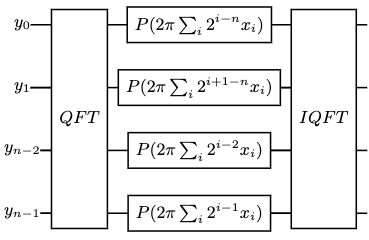

Let us test the QFT adder with several examples.

In [9]:
from quantum_walk import qft
from braket.circuits import Circuit


def qft_add(num_qubits: int, const: int):
    
    qc = Circuit()

    N = num_qubits-1

    bin_const = [int(x) for x in bin(abs(const))[2:]] # Big endian
    bin_const = [0]*(N-len(bin_const)) + bin_const

    
    for n in range(1, N+1):
        if bin_const[n-1]:
            qc.phaseshift(N, np.sign(const) * 2*np.pi / 2**(n+1))

    for i in range(1, N+1):
        for n in range(N-i+1):
            if bin_const[n+i-1]:
                qc.phaseshift(N-i, np.sign(const) * 2*np.pi / 2**(n+1))

    return qc

def qft_adder(a, b, num_qubits):
    qc = Circuit()

    # Step 1: Encode the number a into the qr_data register
    binary_a = bin(abs(a))[2:]
    for i, bit in enumerate(reversed(binary_a)):
        if bit == '1':
            qc.x(i)
    
    # Step 2: Apply Quantum Fourier Transform
    qc.add_circuit(qft(num_qubits))
    
    # Step 3: Add the number b using QFT adder
    qc.add_circuit(qft_add(num_qubits, b))
    
    # Step 4: Apply Inverse Fourier Transform
    qc.add_circuit(qft(num_qubits, inverse=True))
    
    return qc



In [10]:
device = LocalSimulator()
def test_qft_adder(a, b, num_qubits):
    """ Calculate a + b using the QFT adder. """
    
    qc = qft_adder(a, b, num_qubits)
    result = device.run(qc, shots=1000).result()
    counts = result.measurement_counts
    
    # Make sure the measurement outcome corresponds to the addition a+b
    values = np.asarray([int(v[::-1], 2) for v in counts.keys()])
    
    counts = np.asarray(list(counts.values()))
    c = values[np.argmax(counts)]
    assert np.mod(a+b-c, 2**num_qubits) == 0
    

test_qft_adder(5, 3, 4)
test_qft_adder(4, 5, 5)
test_qft_adder(1, 0, 2)

test_qft_adder(5, -3, 4)
test_qft_adder(5, -2, 4)
test_qft_adder(1, 0, 2)

n = 4
for i in range(2**n):
    test_qft_adder(i, 2, n)
    test_qft_adder(i, -1, n)    

Given now we have understood the QFT adder, let us modify it such that we can perform conditional addition and subtraction for a quantum walker. To achieve that, we will need to add a coin qubit, which is used to control if the control-Z gate (for addition) or its adjoint (for subtraction) is applied to the QFT adder circuit. The circuit for the conditional QFT adder is shown below. There we have $\theta_i=2\pi\sum_j2^{j+i-n}$, and we use $y_{-1}$ to denote the coin qubit, and the control gates reads
\begin{align}
\text{C}\tilde{\text{P}}(\theta) = \text{diag}(0, e^{-i\theta}, 0, e^{i\theta}) = \text{CP}(\theta)\text{CP}_{01}(-\theta),
\end{align}
where 
\begin{align}
\text{CP}(\theta) &= \text{diag}(0, 0, 0, e^{i\theta})\\
\text{CP}_{01}(\theta) &= \text{diag}(0, e^{i\theta}, 0, 0)
\end{align}
are built-in gates in the Amazon Braket SDK. 

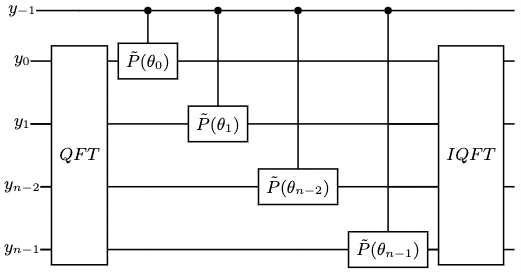
